# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import keras
import sklearn

print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"matplotlib version: {mplt.__version__}")
print(f"PIL version: {PIL.__version__}")
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")
print(f"sklearn version: {sklearn.__version__}")

numpy version: 2.0.2
pandas version: 2.2.2
seaborn version: 0.13.2
matplotlib version: 3.10.0
PIL version: 11.1.0
tensorflow version: 2.18.0
keras version: 3.8.0
sklearn version: 1.6.1


In [55]:
# Import essential libraries
import zipfile
import os, gc
import random

try:
    from google.colab import drive
    IN_GCOLAB=True
except:
    IN_GCOLAB=False

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers  # Import the layers module
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Load the dataset.

In [56]:
# Load and unzip the dataset

if IN_GCOLAB:
    drive_dir = '/content/drive'
    root_dir = drive_dir + '/My Drive/Colab Notebooks/CNN Assignment'
    data_dir = root_dir + '/data'
    drive.mount(drive_dir, force_remount=True)
else:
    root_dir = "."
    data_dir = root_dir + '/data'

zip_file_path = root_dir + '/data.zip'

extraction_path = root_dir
print(data_dir)
print(root_dir)
print(zip_file_path)

if not os.path.exists(data_dir):
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extraction_path)

print(f"Successfully extracted to {extraction_path}")

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/CNN Assignment/data
/content/drive/My Drive/Colab Notebooks/CNN Assignment
/content/drive/My Drive/Colab Notebooks/CNN Assignment/data.zip
Successfully extracted to /content/drive/My Drive/Colab Notebooks/CNN Assignment


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [57]:
# Create a function to load the raw images

def load_raw_image(file_path):
    try:
        img = Image.open(file_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None
    return img

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [58]:
# Get the images and their labels

from collections import defaultdict

class_names = []
images = dict()
labels = dict()

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue  # Skip non-directory entries

    class_names.append(class_name)
    class_index = len(class_names) - 1
    images[class_index] = []
    labels[class_name] = class_index

    for image_name in os.listdir(class_dir):
        try:
            img_path = os.path.join(class_dir, image_name)
            images[class_index].append(load_raw_image(img_path))
        except Exception as e:
            print(f"Error loading image '{image_name}': {e}")

print("Class Indexes:", images.keys())
print("Class Names:", class_names)
print("Label Mapping:", labels)

Class Indexes: dict_keys([0, 1, 2, 3, 4, 5, 6])
Class Names: ['Food_Waste', 'Paper', 'Cardboard', 'Other', 'Glass', 'Metal', 'Plastic']
Label Mapping: {'Food_Waste': 0, 'Paper': 1, 'Cardboard': 2, 'Other': 3, 'Glass': 4, 'Metal': 5, 'Plastic': 6}


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

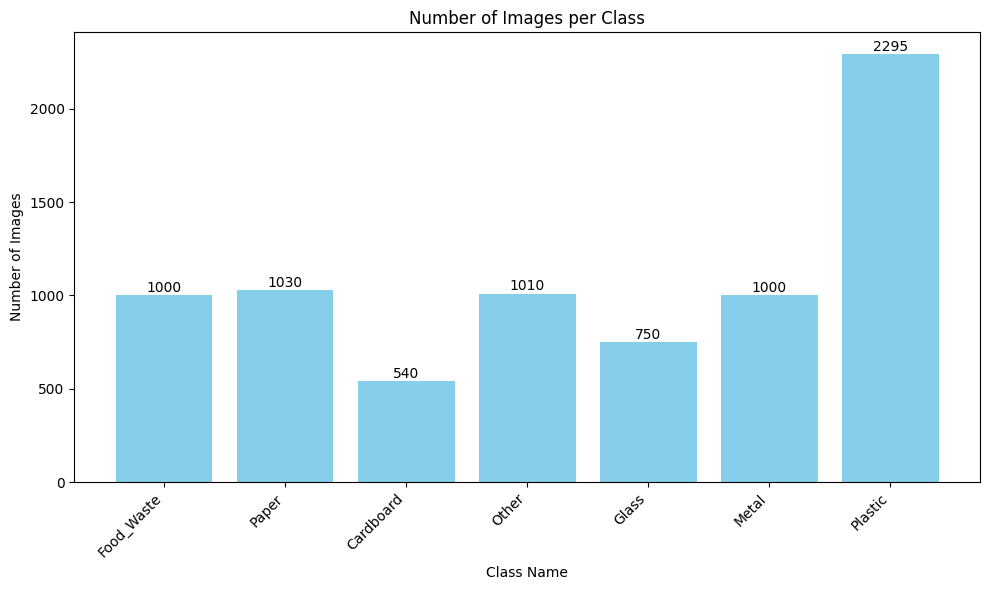

In [59]:
# Visualise Data Distribution

def plot_image_count_bar_chart(class_names, images):
    class_counts = [len(images[i]) for i in range(len(class_names))]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, class_counts, color='skyblue')

    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{int(height)}', ha='center', va='bottom')

    plt.xlabel('Class Name')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_image_count_bar_chart(class_names, images)

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

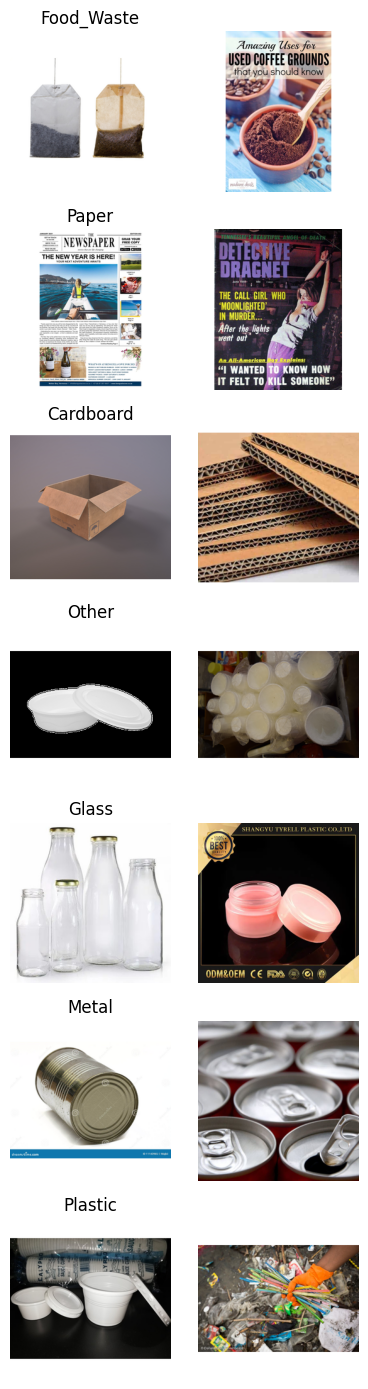

In [60]:
# Visualise Sample Images (across different labels)

def plot_sample_images(images, class_names, num_images):
    """ num_images per class can be passed as parameters for displaying the same images """
    plt.figure(figsize=(num_images * 2, len(class_names) * 2))

    for class_index, class_name in enumerate(class_names):
        class_images = images[class_index]
        display_count = min(num_images, len(class_images))

        for i in range(display_count):
            plt.subplot(len(class_names), num_images, class_index * num_images + i + 1)
            img = class_images[i]
            plt.imshow(img)
            if i == 0: # print the label first time for every class
                plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(images, class_names, 2) #displaying two sample images from every class by passing value 2

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [61]:
# Find the smallest and largest image dimensions from the data set

min_width=0
min_height=0
max_width=0
max_height=0
for image in [img for imgs in images.values() for img in imgs]:
    width, height = image.size
    min_width = min(min_width, width)
    min_height = min(min_height, height)
    max_width = max(max_width, width)
    max_height = max(max_height, height)

print(min_height)
print(min_width)
print(max_width)
print(max_height)

0
0
256
256


Resizing images for class 0...
Resizing images for class 1...
Resizing images for class 2...
Resizing images for class 3...
Resizing images for class 4...
Resizing images for class 5...
Resizing images for class 6...


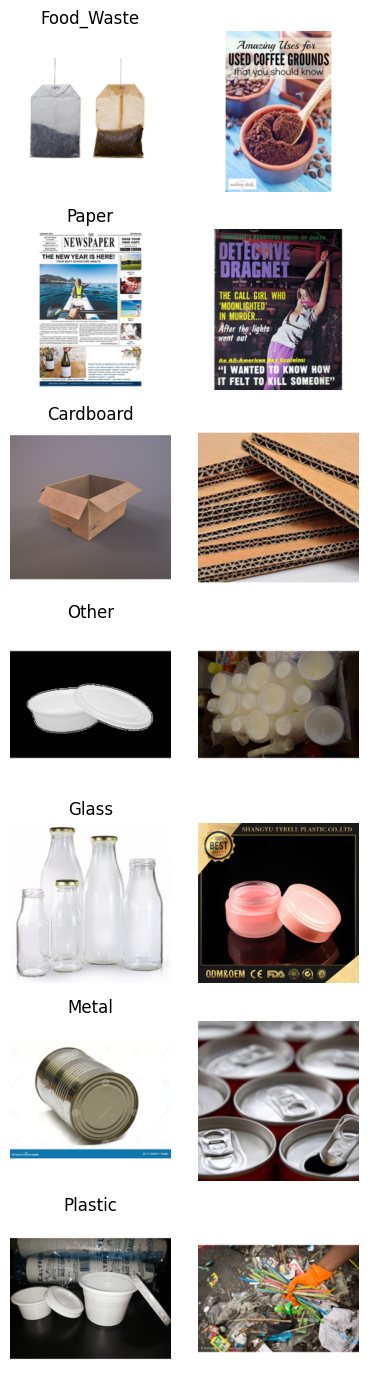

50310

In [62]:
# Resize the image dimensions

image_size = (224,224)
resized_images = dict()

for class_index, image_list in images.items():
    resized_images[class_index] = list()
    print(f"Resizing images for class {class_index}...")

    for image in image_list:
        resized_images[class_index].append(image.resize(image_size))

plot_sample_images(resized_images, class_names, 2) #displaying two sample images from every class by passing value 2
del images # To free up the memory used by images
gc.collect() # Force garbage collection

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [63]:
# Encode the labels suitably

label_encoder = LabelEncoder()
encoded_class_names = label_encoder.fit_transform(class_names)

# Mapping class names to encoded labels
for name, encoded in zip(class_names, encoded_class_names):
    print(f"{name} → {encoded}")


Food_Waste → 1
Paper → 5
Cardboard → 0
Other → 4
Glass → 2
Metal → 3
Plastic → 6


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [64]:
# Assign specified parts of the dataset to train and validation sets

# Flatten resized_images into image_array and encoded_labels
image_array = []
encoded_labels = []

for class_index, image_list in resized_images.items():
    for img in image_list:
        image_array.append(np.array(img))
        encoded_labels.append(class_index)

image_array = np.array(image_array)
encoded_labels = np.array(encoded_labels)

# Normalize pixel values to [0,1]
image_array = image_array / 255.0

# Section 3.2.1: It requires "Evaluate the model on test dataset".
# While training validation data will be used and test used to model evaluation.
# Following will split the data into Train(70%), Validation(15%) and Test (15%)

# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    image_array, encoded_labels, test_size=0.3, random_state=113, stratify=encoded_labels)

# Second split: Split Temp (30%) into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=113, stratify=y_temp)

# Print to verify
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (5337, 224, 224, 3), (5337,)
Validation set: (1144, 224, 224, 3), (1144,)
Test set: (1144, 224, 224, 3), (1144,)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [65]:
# Build and compile the model

min_height, min_width = image_size

configurations = [
    {'name': 'Config 1', 'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.2, 'conv_layers': 3, 'padding': 'valid'}, # excludes padding
    {'name': 'Config 2', 'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.3, 'conv_layers': 3, 'padding': 'same'}, # output same as input padding
    {'name': 'Config 3', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.4, 'conv_layers': 3, 'padding': 'valid'}, # increased filter 32 to 64
]


def create_model(config):
    model = Sequential()
    model.add(Input(shape=(min_height, min_width, 3)))

    # Add convolutional layers
    for i in range(config['conv_layers']):
        # Use the same number of filters for each layer based on the configuration
        model.add(Conv2D(config['filters'],
                config['kernel_size'],
                padding=config['padding'],
                activation=config['activation']))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=config['pool_size']))

    # Flatten and add dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(config['dropout_rate']))
    model.add(Dense(len(set(encoded_labels)), activation='softmax'))  # Output layer

    return model

# model = create_model(configurations[0])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [66]:
%timeit
# Training

models = list()

def train_model(X_train, y_train, X_val, y_val):
  epochs = 10
  batch_size = 32
  history_dict = dict()

  # Train models for each configuration
  for config in configurations:
      print(f"Training {config['name']}...")

      # Create the model based on the configuration
      model = create_model(config)

      # Compile the model
      model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

      # Train the model
      history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
      history_dict[config['name']] = history.history

      models.append(model)

      # Evaluate the model on train set
      loss, accuracy = model.evaluate(X_train, y_train)
      print(f"Train Set Loss: {loss}, Accuracy: {accuracy}")

  return history, history_dict

history, history_dict = train_model(X_train, y_train, X_val, y_val)

Training Config 1...
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.2832 - loss: 3.2186 - val_accuracy: 0.0839 - val_loss: 4.0813
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3447 - loss: 1.6966 - val_accuracy: 0.3409 - val_loss: 1.8013
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4110 - loss: 1.5630 - val_accuracy: 0.2823 - val_loss: 2.0637
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.4392 - loss: 1.4523 - val_accuracy: 0.4572 - val_loss: 1.4606
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5171 - loss: 1.2703 - val_accuracy: 0.4021 - val_loss: 3.8264
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5280 - loss: 1.1926 - val_accuracy: 0.4895 - val_loss: 1.4244
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5825 - loss: 1.0640 - val_accuracy: 0.3872 - val_loss: 2.9939
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6204 - l

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

Config 1: Final Validation Accuracy = 0.4720
Config 2: Final Validation Accuracy = 0.3802
Config 3: Final Validation Accuracy = 0.3628

Best Model: Config 1 with Validation Accuracy: 0.4720
Evaluating 0 Config 1 on the test set...
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4839 - loss: 1.9330
Test Loss: 2.0219244956970215, Test Accuracy: 0.4597901999950409
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Classification Report:
              precision    recall  f1-score   support

  Food_Waste       0.28      0.86      0.42       150
       Paper       0.58      0.32      0.41       155
   Cardboard       0.68      0.51      0.58        81
       Other       0.44      0.22      0.29       152
       Glass       0.65      0.25      0.36       112
       Metal       0.45      0.25      0.32       150
     Plastic       0.63      0.60      0.62       344

    accuracy                           0.46      1144
   macro avg       0.53      0.43      0.43      1144
weighted avg       0.53  

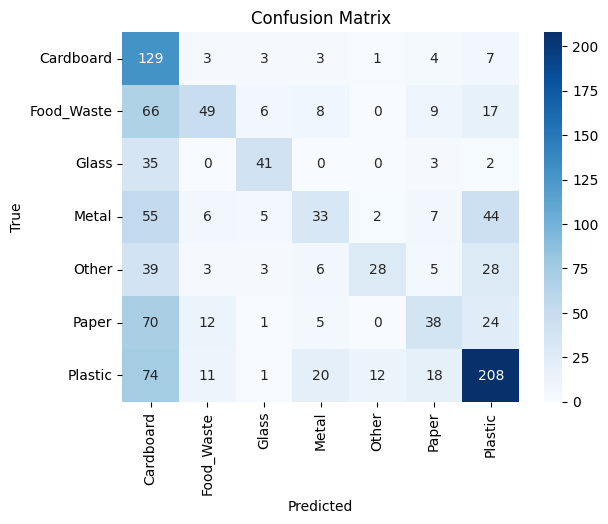

In [67]:
# Evaluate on the test set; display suitable metrics

def model_test_and_evaluate(history, history_dict):
  best_model_name = None
  best_val_accuracy = 0

  for config_name, history in history_dict.items():
      val_acc = history['val_accuracy'][-1]  # Accuracy at final epoch
      print(f"{config_name}: Final Validation Accuracy = {val_acc:.4f}")

      if val_acc > best_val_accuracy:
          best_val_accuracy = val_acc
          best_model_name = config_name

  print(f"\nBest Model: {best_model_name} with Validation Accuracy: {best_val_accuracy:.4f}")

  def get_config_index_by_name(configurations, name):
      for idx, config in enumerate(configurations):
          if config['name'] == name:
              return idx
      return -1  # Not found

  best_model_index = get_config_index_by_name(configurations, best_model_name)

  model = models[best_model_index]

  print(f"Evaluating {best_model_index} {configurations[best_model_index]['name']} on the test set...")

  # Assuming model has been trained already or using the final model after training
  # Evaluate the model on the test set
  loss, accuracy = model.evaluate(X_test, y_test)
  print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

  # Predict the test set labels
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

  # Print the classification report with additional metrics
  print("Classification Report:")
  print(classification_report(y_test, y_pred_classes, target_names=class_names))

  cm = confusion_matrix(y_test, y_pred_classes)
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

model_test_and_evaluate(history, history_dict)

# With the confusion matrix it is also clear the accuracy is low due to class imbalance

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [68]:

# Define augmentation steps to augment images

for class_index in resized_images:
    print(f"Class {class_index}: {len(resized_images[class_index])} images")


Class 0: 1000 images
Class 1: 1030 images
Class 2: 540 images
Class 3: 1010 images
Class 4: 750 images
Class 5: 1000 images
Class 6: 2295 images


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [69]:
# Create a function to augment the images

# Basic augmentation config
imgen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [70]:
# Create the augmented training dataset

# Step 1: Define the data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

def augment_images(images, num_to_generate):
    augmented_images = []
    images = np.array([np.array(img).astype('float32') / 255.0 for img in images])
    for _ in range(num_to_generate):
        img = random.choice(images)
        augmented_img = data_augmentation(tf.expand_dims(img, 0), training=True)
        augmented_images.append(np.array(augmented_img[0]))
    return augmented_images


# Step 2: Find average sample count
sample_counts = [len(imgs) for imgs in resized_images.values()]
avg_samples = int(np.mean(sample_counts))
print(f"Target samples per class: {avg_samples}")

# Step 3: Balance data with augmentation
balanced_images = []
balanced_labels = []

for class_index, img_list in resized_images.items():
    current_count = len(img_list)

    if current_count > avg_samples: # select upto avg samples
        selected = random.sample(img_list, avg_samples)
        balanced_images.extend([np.array(img) for img in selected])
        balanced_labels.extend([class_index] * avg_samples)

    elif current_count < avg_samples: # increase the sample by generating images
        # Load the images upto current_count
        needed = avg_samples - current_count
        base_images = img_list
        balanced_images.extend([np.array(img) for img in base_images])
        balanced_labels.extend([class_index] * len(base_images))
        # Generate the images to reach the avg sample size
        augmented = augment_images(base_images, needed)
        balanced_images.extend([np.array((img * 255).astype('uint8')) for img in augmented])
        balanced_labels.extend([class_index] * needed)

    else: # if the sample size if equal to avg sample size simply load all
        balanced_images.extend([np.array(img) for img in img_list])
        balanced_labels.extend([class_index] * current_count)
    print(f"Augmented of images of class {class_index} completed!")

del resized_images # To free up the memory used by resized_images
gc.collect() # Force garbage collection

Target samples per class: 1089
Augmented of images of class 0 completed!
Augmented of images of class 1 completed!
Augmented of images of class 2 completed!
Augmented of images of class 3 completed!
Augmented of images of class 4 completed!
Augmented of images of class 5 completed!
Augmented of images of class 6 completed!


38223

In [71]:
print(len(balanced_images))
print(len(balanced_labels))

7623
7623


##### **4.1.2**

Train the model on the new augmented dataset.

Training Config 1...
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.2380 - loss: 3.2509 - val_accuracy: 0.1934 - val_loss: 2.1699
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.3256 - loss: 1.7523 - val_accuracy: 0.2616 - val_loss: 1.9899
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3863 - loss: 1.6276 - val_accuracy: 0.2555 - val_loss: 2.4499
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4203 - loss: 1.5635 - val_accuracy: 0.2528 - val_loss: 2.4433
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.4777 - loss: 1.4072 - val_accuracy: 0.2817 - val_loss: 2.0071
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5058 - loss: 1.3076 - val_accuracy: 0.4024 - val_loss: 1.8154
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5659 - loss: 1.1528 - val_accuracy: 0.4059 - val_loss: 2.0423
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6012 - l

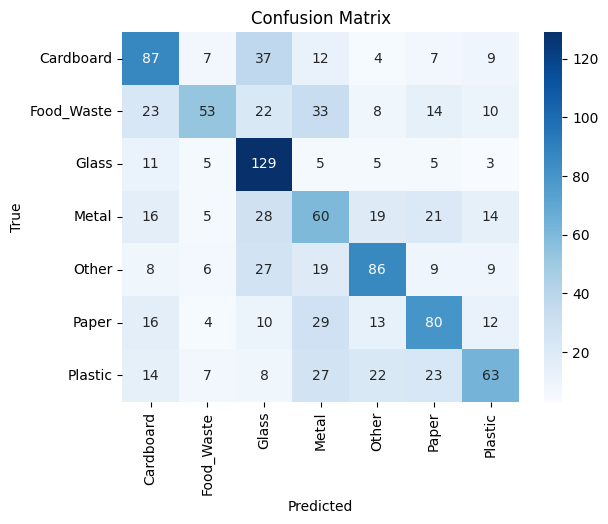

In [72]:
# Train the model using augmented images
X = np.array(balanced_images).astype('float32') / 255.0  # Normalize to [0,1]
y = np.array(balanced_labels)

del models # To free up the memory used
gc.collect() # Force garbage collection
models = list()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=113)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=113)


history, history_dict = train_model(X_train, y_train, X_val, y_val)
model_test_and_evaluate(history, history_dict)

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

# CNN Waste Segregation - Project Report

## Data Insights

- We made a bar chart to see how many images we had in each category. We noticed the number of images wasn't equal across all classes.
- The images were different sizes, so we resized all of them to **224 x 224 pixels**.
- We showed sample images from each class to see what they looked like before and after resizing.
- Since some classes had fewer images, we used **data augmentation** (like flipping and rotating images) to help balance the dataset.
- We split the data into:
  - **70% for training**
  - **15% for validation**
  - **15% for testing**

---

## Model Training Results

### Without Data Augmentation
- **Best Setup:** Config 1  
-Train Set Loss: 1.094040036201477
- Accuracy: 0.6449316143989563
- Test Loss: 2.0219244956970215
- Test Accuracy: 0.4597901999950409


### With Data Augmentation
- **Best Setup:** Config 1  
- Train Set Loss: 0.7241321206092834
- Accuracy: 0.7443777918815613
- Test Loss: 1.6369965076446533
- Test Accuracy: 0.4877622425556183

- Tested different model configurations by changing:
  - Filter sizes  
  - Kernel sizes  
  - Dropout rates  
  - Padding methods  
- Trained and tested **3 different models**.
- Used data augmentation tricks like:
  - **Random flips**
  - **Rotations**
  - **Zooming**
- Created a **classification report** with:
  - Precision  
  - Recall  
  - F1-score  
  - Support for each class
- Made a **confusion matrix** to see correct and incorrect predictions.

---

## Conclusion

- **Data augmentation** helped reduce test loss slightly.
- **Class imbalance** is still a challenge.
- We may need **more augmentation or other techniques** to further improve accuracy and lower test loss.